# Exercise 7 - Monte Carlo Localization

In this assignment you need to implement a particle filter algorithm for localizing a robot in a given map. 
The data for this exercise is recorded on a differential drive robot equipped with a 2D laser scanner that moves in the following environment:

In [1]:
# -*- coding: utf-8 -*-
import pickle

import matplotlib.pyplot as plt
import numpy as np


def world2map(pose, gridmap, map_res):
    max_y = np.size(gridmap, 0) - 1
    new_pose = np.zeros_like(pose)
    new_pose[0] = np.round(pose[0] / map_res)
    new_pose[1] = max_y - np.round(pose[1] / map_res)
    return new_pose.astype(int)


def v2t(pose):
    c = np.cos(pose[2])
    s = np.sin(pose[2])
    tr = np.array([[c, -s, pose[0]], [s, c, pose[1]], [0, 0, 1]])
    return tr


def t2v(tr):
    x = tr[0, 2]
    y = tr[1, 2]
    th = np.arctan2(tr[1, 0], tr[0, 0])
    v = np.array([x, y, th])
    return v


def ranges2points(ranges, angles):
    # rays within range
    max_range = 80
    idx = (ranges < max_range) & (ranges > 0)
    # 2D points
    points = np.array([
        np.multiply(ranges[idx], np.cos(angles[idx])),
        np.multiply(ranges[idx], np.sin(angles[idx]))
    ])
    # homogeneous points
    points_hom = np.append(points, np.ones((1, np.size(points, 1))), axis=0)
    return points_hom


def ranges2cells(r_ranges, r_angles, w_pose, gridmap, map_res):
    # ranges to points
    r_points = ranges2points(r_ranges, r_angles)
    w_P = v2t(w_pose)
    w_points = np.matmul(w_P, r_points)
    # world to map
    m_points = world2map(w_points, gridmap, map_res)
    m_points = m_points[0:2, :]
    return m_points


def poses2cells(w_pose, gridmap, map_res):
    # covert to map frame
    m_pose = world2map(w_pose, gridmap, map_res)
    return m_pose


def init_uniform(num_particles, img_map, map_res):
    particles = np.zeros((num_particles, 4))
    particles[:, 0] = np.random.rand(num_particles) * np.size(img_map,
                                                              1) * map_res
    particles[:, 1] = np.random.rand(num_particles) * np.size(img_map,
                                                              0) * map_res
    particles[:, 2] = np.random.rand(num_particles) * 2 * np.pi
    particles[:, 3] = 1.0
    return particles


def plot_particles(particles, img_map, map_res):
    plt.matshow(img_map, cmap="gray")
    max_y = np.size(img_map, 0) - 1
    xs = np.copy(particles[:, 0]) / map_res
    ys = max_y - np.copy(particles[:, 1]) / map_res
    plt.plot(xs, ys, '.b')
    plt.xlim(0, np.size(img_map, 1))
    plt.ylim(0, np.size(img_map, 0))
    plt.show()


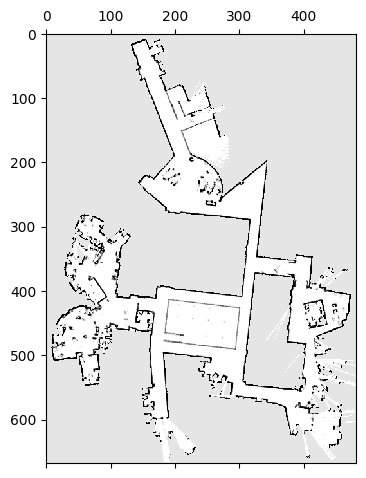

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = pickle.load(open("dataset_mit_csail.p", "rb"))

plt.matshow(data['img_map'], cmap="gray")
plt.show()

The following data is provided in `data`:

- *img_map* is the image of the environment where the robot must localize
- *likelihood_map* is the likelihood map defined over the environment and used for computing the weights of the particles
- *odom* is the noisy odometry readings observed by the robot during navigation in the form: $\delta_{rot1}, \delta_{trans}, \delta_{rot2}$
- *gt_odom* is the ground truth odometry, you may want to use it for checking your results
- *z* are the laser range measurements (37 beams $\rho_i, \phi_i$) obtained by the robot during navigation, where $\rho_i$ is the range and $\theta_i$ the corresponding firing angle defined wrt the robot orientation

You can access the `data` as follows:

In [3]:
# get odometry reading at timestep 25
odom_25 = data['odom'][25]
print("Odom at step 25 is: ", odom_25)

# get ground truth odometry reading at timestep 25
odom_gt_25 = data['gt_odom'][25]
print("True odom at step 25 is: ", odom_25)

# get observed scan at timestep 10
z_10 = data['z'][10]
print("Angles at step 10 is: ", z_10[0,:])
print("Ranges at step 10 is: ", z_10[1,:])

Odom at step 25 is:  [ 0.11378333  0.50803543 -0.18586595]
True odom at step 25 is:  [ 0.11378333  0.50803543 -0.18586595]
Angles at step 10 is:  [-1.570796e+00 -1.483526e+00 -1.396256e+00 -1.308986e+00 -1.221716e+00
 -1.134446e+00 -1.047176e+00 -9.599060e-01 -8.726360e-01 -7.853660e-01
 -6.980960e-01 -6.108260e-01 -5.235560e-01 -4.362860e-01 -3.490160e-01
 -2.617460e-01 -1.744760e-01 -8.720600e-02  6.400000e-05  8.733400e-02
  1.746040e-01  2.618740e-01  3.491440e-01  4.364140e-01  5.236840e-01
  6.109540e-01  6.982240e-01  7.854940e-01  8.727640e-01  9.600340e-01
  1.047304e+00  1.134574e+00  1.221844e+00  1.309114e+00  1.396384e+00
  1.483654e+00  1.570924e+00]
Ranges at step 10 is:  [ 3.    2.99  1.33  1.23  1.16  1.14  1.34  1.43  1.4   2.94  3.    3.07
  3.2   3.22  3.59  3.7   3.86  2.75 81.91  1.65  1.68  1.81 81.91 81.91
  4.73  4.76  3.76  4.18  2.3   2.31  5.7   2.33  2.41  4.23  4.09  4.02
 81.91]


## 7.1 Motion update [1.0]

The `sample_motion_model_odometry` function defines the sampling-based odometry motion model. 

This function takes as input:

- the initial pose of the robot $x_{t-1} = [x,y,\theta]$
- the odometry readings $u_t = [\delta_{rot1}, \delta_{trans}, \delta_{rot2}]$ 
- the noise parameters $\mathbf{\alpha} = [0.1, 0.1, 0.1, 0.1]$

The output is a new (sampled) pose predicted by the motion model.

Implement the `sample_motion_model_odometry` function and verify that it is correct for some test input. 

You **can** re-use the your implementation from Exercise 3. 

In [6]:
def sample_motion_model_odometry(x_t_minus_1, u_t, alpha):
    x=x_t_minus_1[0]
    y=x_t_minus_1[1]
    theta=x_t_minus_1[2]

    delta_rot1=u_t[0]
    delta_trans=u_t[1]
    delta_rot2=u_t[2]

    var_rot1=alpha[0]*abs(delta_rot1)+alpha[1]*abs(delta_trans)
    var_trans=alpha[2]*abs(delta_trans)+alpha[3]*(abs(delta_rot1)+abs(delta_rot2))
    var_rot2=alpha[0]*abs(delta_rot2)+alpha[1]*abs(delta_trans)

    delta_rot1_hat=delta_rot1+np.random.normal(0, np.sqrt(var_rot1))
    delta_trans_hat=delta_trans+np.random.normal(0, np.sqrt(var_trans))
    delta_rot2_hat=delta_rot2+np.random.normal(0, np.sqrt(var_rot2))

    x_new=x+delta_trans_hat*np.cos(theta+delta_rot1_hat)
    y_new=y+delta_trans_hat*np.sin(theta+delta_rot1_hat)
    theta_new=theta+delta_rot1_hat+delta_rot2_hat

    x_t=np.array([x_new, y_new, theta_new])

    return x_t

In [9]:
x_t_minus_1=np.array([2.0, 1.0, np.pi/4])  # start at (2, 1) facing 45°
u_t=np.array([0.3, 1.0, 0.2])  # rot1=0.3, trans=1.0, rot2=0.2
alpha=np.array([0.1, 0.1, 0.1, 0.1])

np.random.seed(42)
samples_list=[]
for i in range(500):
    pose=sample_motion_model_odometry(x_t_minus_1, u_t, alpha)
    samples_list.append(pose)

samples=np.array(samples_list)

print(f"stats of 500 samples: ")
print(f"\n x: mean={samples[:,0].mean():.4f}, std={samples[:,0].std():.4f}")
print(f"\n y: mean={samples[:,1].mean():.4f}, std={samples[:,1].std():.4f}")
print(f"\n theta: mean={samples[:,2].mean():.4f}, std={samples[:,2].std():.4f}")


stats of 500 samples: 

 x: mean=2.4051, std=0.3534

 y: mean=1.8402, std=0.3646

 theta: mean=1.3477, std=0.4933


## 7.2 Compute weights [3.0]

The `compute_weights` function is responsible for computing the importance weight for each particle according to the observation model, i.e.,

$$w_{i,t} = \eta\,p(z_{t}|x_{i,t}).$$

The motion model is obtained by querying the likelihood map defined over the environment in the endpoints of the laser scan ranges.

The available `ranges2cells` function computes the endpoints of raw scans $(\rho, \phi)$ into map coordinates.

Implement the `compute_weights` function and verify that it is correct for some test input. 

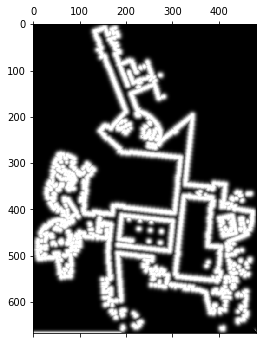

In [4]:
plt.matshow(data['likelihood_map'], cmap="gray")
plt.show()

In [ ]:
def compute_weights(particles, ranges, angles, likelihood_map, map_res, map_origin):

    num_particles=particles.shape[0]
    weights=np.zeros(num_particles)
    


## 7.3 Resampling [3.0]

The `resample` function is responsible for re-sampling particles according to their weight (the higher the more likely to be samples) and, thus, “kills” the particles with low weight.

Implement the `resample` function and verify that it is correct for some test input. 

## 7.4 Localization [3.0]

Once you complete all the above functions, implement the main procedure of Monte Carlo localization `mc_localization` which recursively estimate the position of the robot using the odometry data and the laser scans.

Consider 5000 particles that are intialized uniformly over the environment. 

The map resolution is 0.1 and each particle is a $(x,y,\theta)$ pose.

Plot the belief about the position of the robot after the sequence of odometry readings and laser scans provided in `data` by using the `plot_particles` function.

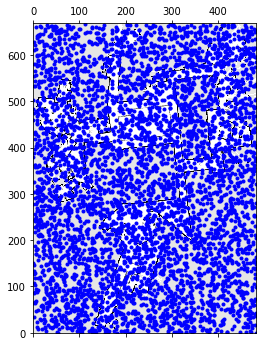

In [5]:
num_particles = 5000
map_res = 0.1

particles = ex.init_uniform(num_particles, data['img_map'], map_res)
ex.plot_particles(particles, data['img_map'], map_res)